In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,LayerNormalization,Input,MultiHeadAttention,Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

In [2]:
tf.__version__

'2.15.0'

# Data Preparation

### https://www.manythings.org/anki/

## Data Processing

In [5]:
text_dataset=tf.data.TextLineDataset("deu.txt")

In [4]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=32
GERMAN_SEQUENCE_LENGTH=32
BATCH_SIZE=128

In [10]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [11]:
split_dataset=text_dataset.map(selector)

In [12]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [13]:
init_dataset=text_dataset.map(separator)

In [15]:
for i in split_dataset.take(2):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Geh.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Geh. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Hi.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Hallo!'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Hallo! endtoken'], dtype=object)>)


In [ ]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [6]:
german_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=GERMAN_SEQUENCE_LENGTH
)

In [16]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)

In [17]:
german_training_data=init_dataset.map(lambda x,y:y)### input x,y and output y
german_vectorize_layer.adapt(german_training_data)#### adapt the vectorize_layer to the training data

In [18]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':german_vectorize_layer(inputs['input_2'])},german_vectorize_layer(output)

In [20]:
dataset=split_dataset.map(vectorizer)

In [22]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[48,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[  2, 593,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[593,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>)


In [24]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
NUM_BATCHES=int(250000/BATCH_SIZE)

In [27]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [28]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

# Modeling

## Embedding

In [30]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [32]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

## Custom MultiHeadAttention

In [36]:
class CustomSelfAttention(Layer):
  def __init__(self,model_size):
    super(CustomSelfAttention,self).__init__()
    self.model_size=model_size
  def call(self,query,key,value,masking):
    ######## compute scores
    score=tf.matmul(query,key,transpose_b=True)
    ######## scaling
    score/=tf.math.sqrt(tf.cast(self.model_size,tf.float32))
    ######## masking
    # masking=tf.cast(masking,dtype=tf.float32)
    # score+=(1.-masking)*-1e10
    ######## attention_weights
    attention=tf.nn.softmax(score,axis=-1) #*masking
    ######## output
    head=tf.matmul(attention,value)
    return head

In [38]:
class CustomMultiHeadAttention(Layer):
  def __init__(self,num_heads,key_dim):
    super(CustomMultiHeadAttention,self).__init__()

    self.num_heads=num_heads
    self.dense_q=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_k=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_v=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_o=Dense(key_dim)
    self.self_attention=CustomSelfAttention(key_dim)

  def call(self,query,key,value,attention_mask):
    heads=[]

    for i in range(self.num_heads):
      print("hello", self.dense_q[i](query).shape)
      head=self.self_attention(self.dense_q[i](query),self.dense_k[i](key),
                              self.dense_v[i](value),attention_mask)
      heads.append(head)
    print("head", tf.convert_to_tensor(heads).shape)
    heads=tf.concat(heads,axis=2)
    heads=self.dense_o(heads)
    return heads

## Encoder

In [40]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = CustomMultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):

      if mask is not None:
        mask = tf.cast(
            mask[:,tf.newaxis, :], dtype="int32")
        T = tf.shape(mask)[2]
        padding_mask = tf.repeat(mask,T,axis=1)
      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,
          attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

## Decoder

In [42]:
print(tf.linalg.band_part(
        tf.ones([1,8, 8],dtype=tf.int32),-1,0))

tf.Tensor(
[[[1 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0]
  [1 1 1 1 0 0 0 0]
  [1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1]]], shape=(1, 8, 8), dtype=int32)


In [43]:
class TransformerDecoder(Layer):
  def __init__(self, embed_dim, latent_dim, num_heads,):
    super(TransformerDecoder, self).__init__()
    self.embed_dim = embed_dim
    self.latent_dim = latent_dim
    self.num_heads = num_heads
    self.attention_1=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.attention_2=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = tf.keras.Sequential(
        [Dense(latent_dim, activation="relu"),Dense(embed_dim),]
    )
    self.layernorm_1=LayerNormalization()
    self.layernorm_2=LayerNormalization()
    self.layernorm_3=LayerNormalization()
    self.supports_masking = True
  def call(self, inputs, encoder_outputs, enc_mask, mask): #=None):


    if mask is not None:
      causal_mask=tf.linalg.band_part(
        tf.ones([tf.shape(inputs)[0],
                 tf.shape(inputs)[1],
                 tf.shape(inputs)[1]],dtype=tf.int32),-1,0)
      mask = tf.cast(
          mask[:,tf.newaxis, :], dtype="int32")
      enc_mask = tf.cast(
          enc_mask[:,tf.newaxis, :], dtype="int32")
      T = tf.shape(mask)[2]
      padding_mask = tf.repeat(mask,T,axis=1)
      cross_attn_mask = tf.repeat(enc_mask,T,axis=1)
      combined_mask=tf.minimum(padding_mask,causal_mask)

    attention_output_1 = self.attention_1(
        query=inputs,key=inputs,value=inputs,
        attention_mask=combined_mask,

    )

    out_1 = self.layernorm_1(inputs + attention_output_1)

    attention_output_2= self.attention_2(
        query=out_1,key=encoder_outputs,value=encoder_outputs,
        attention_mask=cross_attn_mask,

    )
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    proj_output = self.dense_proj(out_2)
    return self.layernorm_3(out_2 + proj_output)

## Transformer Model

In [45]:
EMBEDDING_DIM=512
D_FF=2048
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=10

In [46]:
encoder_inputs=Input(shape=(None,), dtype="int64", name="input_1")
emb = Embeddings(ENGLISH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)
x = emb(encoder_inputs)
enc_mask = emb.compute_mask(encoder_inputs)

for _ in range(NUM_LAYERS):
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)
encoder_outputs=x

decoder_inputs=Input(shape=(None,), dtype="int64", name="input_2")

x = Embeddings(GERMAN_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(decoder_inputs)
for i in range(NUM_LAYERS):
  x=TransformerDecoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x, encoder_outputs,enc_mask)
x=tf.keras.layers.Dropout(0.5)(x)
decoder_outputs=Dense(VOCAB_SIZE, activation="softmax")(x)

transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embeddings_1 (Embeddings)   (None, 32, 512)              1024000   ['input_1[0][0]']             
                                                          0                                    

# Training

In [48]:
class Scheduler(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps):
    super(Scheduler, self).__init__()
    self.d_model = tf.cast(d_model, tf.float64)
    self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float64)

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float64)
    return (self.d_model**(-0.5))*tf.math.minimum(step**(-0.5), step * (self.warmup_steps ** -1.5))

In [49]:
WARM_UP_STEPS = 4000
lr_scheduled = Scheduler(EMBEDDING_DIM, WARM_UP_STEPS)

In [50]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(lr_scheduled, beta_1=0.9, beta_2=0.98, epsilon=1e-9),)

In [51]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
   1757/Unknown - 522s 284ms/step - loss: 5.1460hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
1757/1757 [==============================] - 612s 335ms/step - loss: 5.1460 - val_loss: 4.6706
Epoch 2/10
1757/1757 [==============================] - 571s 325ms/step - loss: 2.8918 - val_loss: 3.6823
Epoch 3/10
1757/1757 [==============================] - 570s 324ms/step - loss: 2.2484 - val_loss: 3.3401
Epoch 4/10
1757/1757 [==============================] - 571s 

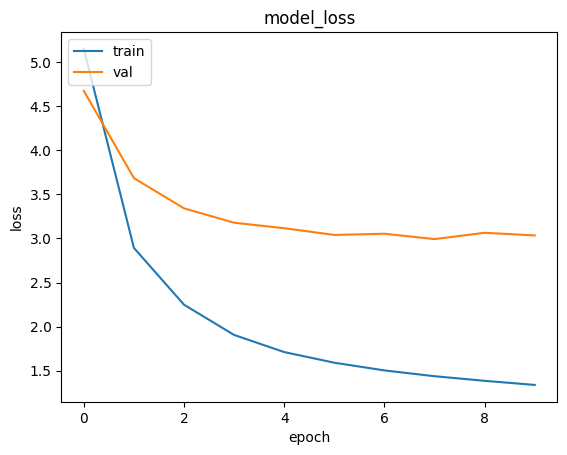

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing

In [53]:
index_to_word={x:y for x, y in zip(range(len(german_vectorize_layer.get_vocabulary())),
                                   german_vectorize_layer.get_vocabulary())}

In [54]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(GERMAN_SEQUENCE_LENGTH):
    tokenized_shifted_target=german_vectorize_layer([shifted_target])
    output=transformer.predict([tokenized_english_sentence,tokenized_shifted_target])
    german_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[german_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [56]:
translator('go')

1/1 [==============================] - 0s 47ms/step


'geh geh hin'

In [57]:
translator('Hi')

1/1 [==============================] - 0s 24ms/step


'hallo hallo'

In [58]:
translator("what is your name?")

1/1 [==============================] - 0s 27ms/step


'wie heißt dein name'

In [59]:
translator('My name is Tom')

1/1 [==============================] - 0s 26ms/step


'mein name ist tom'

In [64]:
translator('I love you')

1/1 [==============================] - 0s 53ms/step


'ich liebe dich sehr gerne'

In [70]:
translator("Yesterday he went shopping")

1/1 [==============================] - 0s 91ms/step


'er ist gestern einkaufen gegangen'

In [ ]:
translator('Tomorrow I will play football')

1/1 [==============================] - 0s 23ms/step


'morgen spiele ich fußball'

In [ ]:
translator('His German is improving')

1/1 [==============================] - 0s 23ms/step


'sein deutsch wird besser'

In [ ]:
translator('I love to write')

1/1 [==============================] - 0s 29ms/step


'ich schreibe gern zu schreiben'

In [ ]:
translator('Perhaps she will come tomorrow')

1/1 [==============================] - 0s 32ms/step


'vielleicht kommt sie morgen'

In [ ]:
translator('She handed him the money')

1/1 [==============================] - 0s 30ms/step


'sie gab ihm das geld'

In [65]:
translator('Will you marry me')

1/1 [==============================] - 0s 42ms/step


'wirst du mich heiraten'